## Думаю, что для тестового задания лучше overexplain, буду пояснять что думал и что делал.
## Надеюсь вы будете запускать это в новом venv с установленным jupyterlab.  
#### Ставим нужные пакеты.

In [1]:
# Install all we need here
import sys

!{sys.executable} -m pip install -q pandas seaborn wordcloud nltk scikit-learn fasttext pymorphy2 tensorflow_text plotly==5.7.0 pyyaml==5.4.1 datasets transformers

     |████████████████████████████████| 68 kB 7.7 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 4.9 MB 64.3 MB/s 
     |████████████████████████████████| 28.8 MB 1.5 MB/s 
     |████████████████████████████████| 636 kB 91.9 MB/s 
     |████████████████████████████████| 325 kB 55.7 MB/s 
     |████████████████████████████████| 4.0 MB 59.2 MB/s 
     |████████████████████████████████| 8.2 MB 26.6 MB/s 
     |████████████████████████████████| 462 kB 75.9 MB/s 
     |████████████████████████████████| 212 kB 56.3 MB/s 
     |████████████████████████████████| 77 kB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 72.0 MB/s 
     |████████████████████████████████| 136 kB 50.0 MB/s 
     |████████████████████████████████| 127 kB 37.4 MB/s 
     |████████████████████████████████| 6.6 MB 51.1 MB/s 
     |████████████████████████████████| 895 kB 54.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████

In [2]:
import re
import os
import string
from collections import Counter
from typing import List

import fasttext
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import psutil
import pymorphy2
from IPython import display
from nltk.corpus import stopwords
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    roc_auc_score,                            
    roc_curve
)
from wordcloud import (
    STOPWORDS, 
    ImageColorGenerator, 
    WordCloud
)

nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Проверим есть ли данные и если их нет, качаем

In [3]:
FILE_PATH = '/content/dataset/train.tsv'


if not os.path.isfile(FILE_PATH):
    !wget https://disk.skbkontur.ru/index.php/s/aknGb6oZSzA8djG/download
    !unzip "/content/download" -d "/content/"


--2022-04-22 09:46:33--  https://disk.skbkontur.ru/index.php/s/aknGb6oZSzA8djG/download
Resolving disk.skbkontur.ru (disk.skbkontur.ru)... 46.17.201.85, 46.17.202.21
Connecting to disk.skbkontur.ru (disk.skbkontur.ru)|46.17.201.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264566 (258K) [application/zip]
Saving to: ‘download’

download            100%[===================>] 258.37K   163KB/s    in 1.6s    

2022-04-22 09:46:37 (163 KB/s) - ‘download’ saved [264566/264566]

Archive:  /content/download
  inflating: /content/dataset/train.tsv  
  inflating: /content/dataset/test.tsv  
  inflating: /content/task.md        


#### Посмтрим на данные

In [4]:
data = pd.read_csv("/content/dataset/train.tsv", sep="\t")

In [5]:
data.head()

title  is_fake
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1  Агент Кокорина назвал езду по встречке житейск...        0
2  Госдума рассмотрит возможность введения секрет...        1
3  ФАС заблокировала поставку скоростных трамваев...        0
4  Против Навального завели дело о недоносительст...        1

In [6]:
data.shape

(5758, 2)

In [7]:
data["is_fake"].value_counts(normalize=True)

1    0.5
0    0.5
Name: is_fake, dtype: float64

In [8]:
data.isnull().sum()

title      0
is_fake    0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


## Подготовим текст для дальнейшей работы. 
### Приведём к нижнему регистру, удалим знаки препинания и другие символы, выбросим стоп-слова, приведём все слова к нормальной форме (лемматизируем)

In [10]:
stop_words = stopwords.words("russian")
stop_words.append("изза")

morph = pymorphy2.MorphAnalyzer()


def remove_punctuations(text: str) -> str:
    """Remove punctuation from given text"""
    return re.sub('\[[^]]*\]', '', text)


def remove_characters(text: str) -> str:
    """Remove characters from given text"""
    return re.sub('[^а-яА-Я]', ' ', text)


def remove_stopwords(text: str) -> str:
    """Remove stop words from given text"""
    result = []
    for token in text.split():
        if token not in stop_words:
            result.append(token)
    return " ".join(result)


def normalize_text(text: str) -> str:
    """Normalize each word in given text"""
    normalized = []
    for element in text.split():
        normalized.append(morph.parse(element)[0].normal_form)
    return " ".join(normalized)


def clear_text(text: str) -> str:
    """Cleans given text"""
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords(text)
    text = normalize_text(text)
    return text


data["title_normalized"] = data["title"].apply(clear_text)
data.head(2)

title  is_fake  \
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1   
1  Агент Кокорина назвал езду по встречке житейск...        0   

                                    title_normalized  
0  москвич владимир клутина приша л сч так вмешат...  
1  агент кокорин назвать езда встречка житейский ...

## Тут красивые картинки со словами по классам. 
### Сначала настоящие новости, потом выдуманные. 

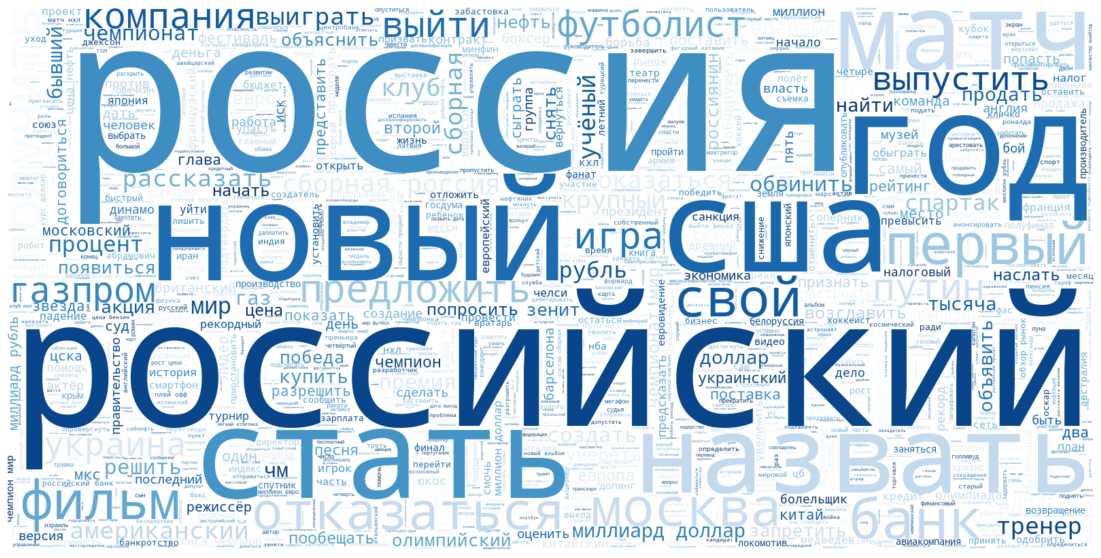

In [11]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Blues").generate(
        " ".join(data[data["is_fake"] == 0]["title_normalized"]
    )
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

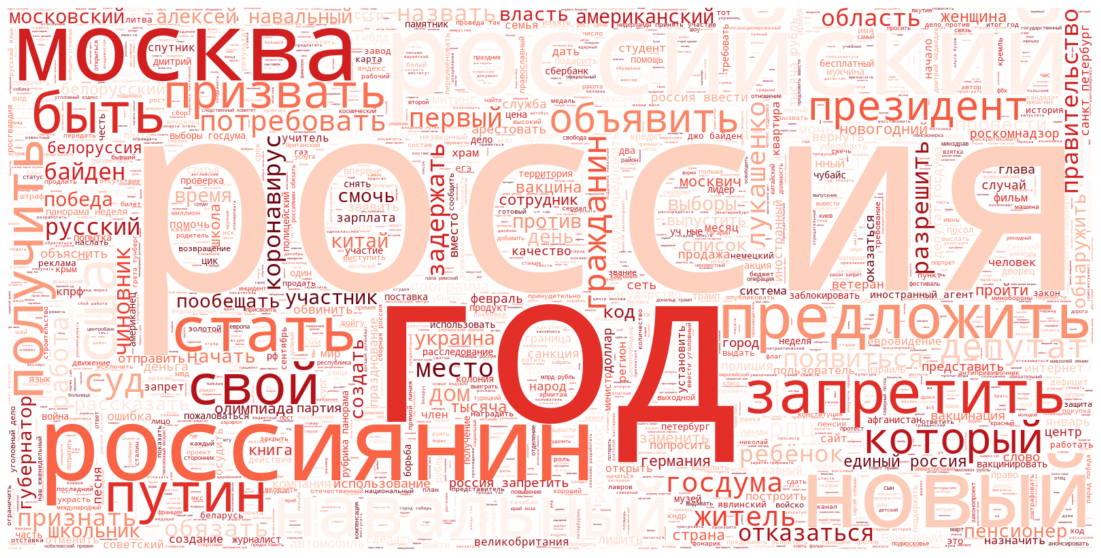

In [12]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Reds").generate(
        " ".join(data[data["is_fake"] == 1]["title_normalized"]
    )
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

### Посмотрим на распределение количества символов / слов в заголовках новостей.  
(Эти plotly диаграммы интерактивные, можно включать/выключать классы)

In [13]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Real', x=data[data["is_fake"] == 0]["title"].str.len()))
fig.add_trace(go.Histogram(name='Fake', x=data[data["is_fake"] == 1]["title"].str.len()))
fig.update_layout(title="Number of characters in the news titles")
fig

In [14]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Real', x=data[data["is_fake"] == 0]["title"].str.split().map(lambda x: len(x))))
fig.add_trace(go.Histogram(name='Fake', x=data[data["is_fake"] == 1]["title"].str.split().map(lambda x: len(x))))
fig.update_layout(title="Number of tokens in the news titles")
fig

## Посмотрим какие слова встречаются в датасете чаще всего. 
### Сначала во всём, а потом в настоящих и выдуманных по отдельности.

In [15]:
all_text = " ".join(data['title_normalized'])

In [16]:
words_counted = Counter(all_text.split())

In [17]:
data_counted = pd.DataFrame.from_dict(words_counted, orient='index', columns=['counter']).sort_values(by='counter', ascending=False).reset_index()
data_counted.head(2)

index  counter
0      россия      536
1  российский      287

In [18]:
fig = px.bar(data_counted[:50], x='index', y='counter', title='The most common tokens in the dataset', labels={'index': 'Token', 'counter': 'Number of occurrences'}, color='index')
fig.show()

In [19]:
all_real_text = " ".join(data[data["is_fake"] == 0]['title_normalized'])
all_fake_text = " ".join(data[data["is_fake"] == 1]['title_normalized'])

real_counted = Counter(all_real_text.split())
fake_counted = Counter(all_fake_text.split())

real_data_counted = pd.DataFrame.from_dict(real_counted, orient='index', columns=['counter']).sort_values(by='counter', ascending=False).reset_index()
fake_data_counted = pd.DataFrame.from_dict(fake_counted, orient='index', columns=['counter']).sort_values(by='counter', ascending=False).reset_index()

In [20]:
fig = px.bar(real_data_counted[:50], x='index', y='counter', title='The most common tokens in real news', labels={'index': 'Token', 'counter': 'Number of occurrences'}, color='index')
fig.show()

In [21]:
fig = px.bar(fake_data_counted[:50], x='index', y='counter', title='The most common tokens in fake news', labels={'index': 'Token', 'counter': 'Number of occurrences'}, color='index')
fig.show()

#### Можно добавить костыль в виде токена "Навальный" при наличии которого новость сразу попадает в выдуманную)

### Посмотрим на слова, котроые не входят в выдуманные новости и наоборот

In [22]:
real_fake = [word for word in real_data_counted['index'].to_list() if word not in fake_data_counted['index'].to_list()]
fake_real = [word for word in fake_data_counted['index'].to_list() if word not in real_data_counted['index'].to_list()]

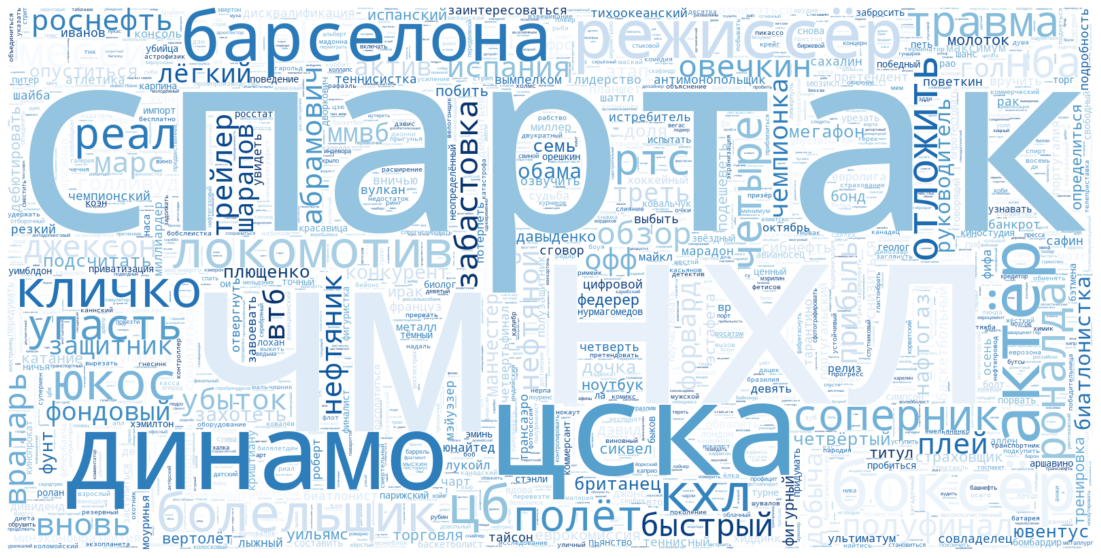

In [23]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Blues").generate(
        " ".join(real_fake)
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

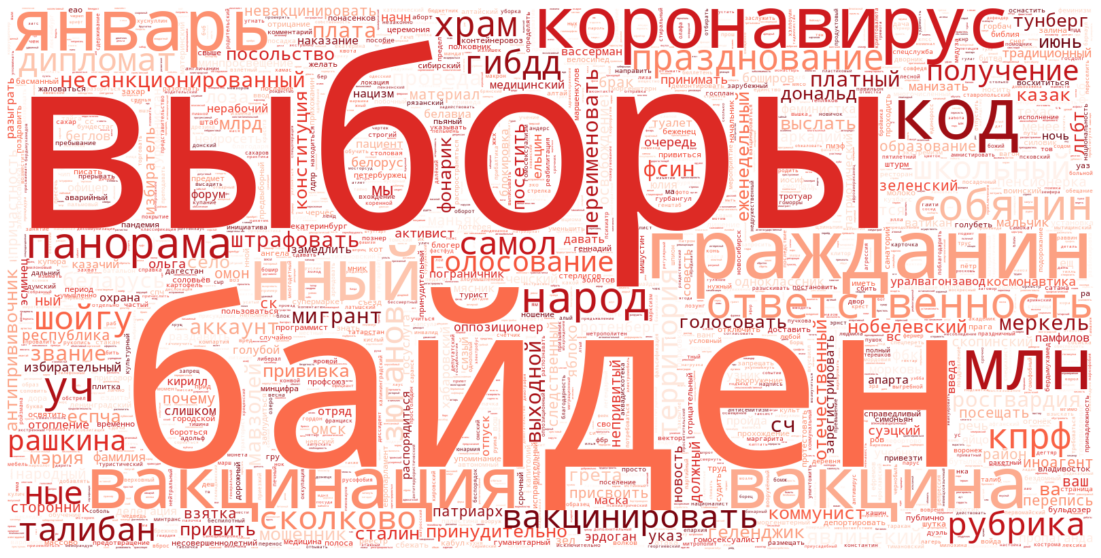

In [103]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(
    max_words=2000, 
    width=1600, 
    height=800, 
    background_color="white", 
    colormap="Reds").generate(
        " ".join(fake_real)
)
plt.axis('off')
plt.imshow(word_cloud, interpolation="bilinear");

# Modeling

In [25]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.3, random_state=118)

In [26]:
data_train.shape, data_test.shape

((4030, 3), (1728, 3))

### Данных мало, тем более у нас только заголовки новостей, без текста.   
Сначала хотелось спарситью всю панораму, добавить столько же из `natasha/corus` и отфильтровать то, что уже есть в датасете, но в чатике написали, что так нельзя.  
Я пробовал добавить больше данных с помощью аугментации - случайно удалял некоторые слова, случайно менял положение слов, удвоил датасет с помощью обратного перевода, но существенного прироста точности это не дало, поэтому оставил исходный и решил работать с ним.






## Fasttext

In [27]:
data_train["fasttext_label"] = data_train["is_fake"].apply(
    lambda label: f"__label__{label}"
)
data_train[["title_normalized", "fasttext_label"]].to_csv(
    "fasttext_corpus.txt",
    sep=" ",
    index=False,
    header=None,
)

In [28]:
model = fasttext.train_supervised(
    "fasttext_corpus.txt",
    dim=200,
    wordNgrams=2,
    ws=1,
    minn=1,
    maxn=200,
    epoch=25,
    thread=psutil.cpu_count(),
)

In [29]:
model.predict("Навальный")[0][0]

'__label__1'

In [30]:
data_test["ft_prediction"] = data_test["title_normalized"].apply(
    lambda title: int(model.predict(title)[0][0].replace("__label__", ""))
)

In [31]:
print(classification_report(data_test["is_fake"], data_test["ft_prediction"]))

              precision    recall  f1-score   support

           0       0.99      0.10      0.18       816
           1       0.55      1.00      0.71       912

    accuracy                           0.58      1728
   macro avg       0.77      0.55      0.45      1728
weighted avg       0.76      0.58      0.46      1728



In [32]:
results = {}
results["fasttext"] = classification_report(
    data_test["is_fake"], data_test["ft_prediction"], output_dict=True
)

## BoW and TF-IDf 
Построим простые классификаторы из `sklearn`

In [33]:
texts_train = data_train["title_normalized"].values.tolist()
texts_test = data_test["title_normalized"].values.tolist()

y_train = data_train["is_fake"].values.tolist()
y_test = data_test["is_fake"].values.tolist()

In [34]:
import itertools

from sklearn import metrics
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import (
    LinearSVC, 
    NuSVC,
    SVC
)

In [35]:
count_vect = CountVectorizer(ngram_range=(1, 2))
tfidf = TfidfVectorizer(min_df=1)

count_train = count_vect.fit_transform(texts_train)
count_test = count_vect.transform(texts_test)

tfidf_train = tfidf.fit_transform(texts_train)
tfidf_test = tfidf.transform(texts_test)

In [36]:
count_train.shape, count_test.shape, tfidf_train.shape, tfidf_test.shape

((4030, 29574), (1728, 29574), (4030, 8395), (1728, 8395))

In [37]:
mnb_count_clf = MultinomialNB(alpha=0.9)
lr_count_clf = LogisticRegression(C=12.0)
mnb_tfidf_clf = MultinomialNB(alpha=0.9)
linear_svc_tfidf_clf = LinearSVC()
sgd_tfidf_clf = SGDClassifier()
svc_tfidf_clf = SVC(kernel="linear")

In [38]:
clfs = [
        (mnb_count_clf, "multinomial nb count"),
        (mnb_tfidf_clf, "multinomial nb tfidf"),
        (lr_count_clf, "logreg count"),
        (linear_svc_tfidf_clf, "svc"),
        (sgd_tfidf_clf, "sgd"),
        (svc_tfidf_clf, "svc_tfidf")
]

In [39]:
def fit_predict(clfs):
    """Fit/predit for all sklearn classifiers"""
    for model, name in clfs:
        model_name = type(model).__name__
        if "count" in name:
            model.fit(count_train, y_train)
            pred = model.predict(count_test)
            results[f"{model_name}CountVectorizer"] = classification_report(
                y_test, pred, output_dict=True
            )
            score = f1_score(y_test, pred)
            print(f"f1 score for {model_name} is: {score}")
        else:
            model.fit(tfidf_train, y_train)
            pred = model.predict(tfidf_test)
            results[f"{model_name}TfIdfVectorizer"] = classification_report(
                y_test, pred, output_dict=True
            ) 
            score = f1_score(y_test, pred)
            print(f"f1 score for {model_name} is: {score}")

In [40]:
fit_predict(clfs)

f1 score for MultinomialNB is: 0.8639240506329113
f1 score for MultinomialNB is: 0.8542116630669545
f1 score for LogisticRegression is: 0.8271752085816448
f1 score for LinearSVC is: 0.8418141592920354
f1 score for SGDClassifier is: 0.8347062053816585
f1 score for SVC is: 0.8372093023255816


## Embeddings
Построим эмбеддинги для нашего тадасета используюя `Universal Sentence Encoder` от `tensorflow`

In [41]:
import tensorflow_hub as hub
import tensorflow_text

In [42]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [43]:
embedded_train = embed(data_train["title_normalized"])
embedded_test = embed(data_test["title_normalized"])

Чтобы использовать векторы текста как фичи для классификаторов сначала нормализуем их

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
sclr = MinMaxScaler()

In [46]:
scaled_embeddings_train = sclr.fit_transform(embedded_train)
scaled_embeddings_test = sclr.fit_transform(embedded_test)

In [47]:
data_embed_train = pd.DataFrame(scaled_embeddings_train)
data_embed_test = pd.DataFrame(scaled_embeddings_test)

In [48]:
data_embed_train.head(2)

0         1         2         3         4         5         6    \
0  0.455995  0.410195  0.567212  0.607125  0.689944  0.287086  0.667847   
1  0.689816  0.535003  0.469931  0.061116  0.446979  0.273902  0.651990   

        7         8         9    ...       502       503       504       505  \
0  0.174514  0.494982  0.654916  ...  0.541390  0.567586  0.571842  0.676205   
1  0.433423  0.920456  0.548313  ...  0.392469  0.415069  0.454845  0.565370   

        506       507       508       509       510       511  
0  0.764274  0.539521  0.372964  0.736091  0.434684  0.728803  
1  0.439742  0.580694  0.604359  0.458970  0.408754  0.553654  

[2 rows x 512 columns]

Попробуем градиентный бустинг и случайный лес из `sklearn`

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [50]:
gbclf = GradientBoostingClassifier(n_estimators=100,
                                   max_depth=8)

In [51]:
gbclf.fit(data_embed_train, y_train)
pred = gbclf.predict(data_embed_test)
results["GradientBoostingClassifier"] = classification_report(
    y_test, pred, output_dict=True
)
f1_score(y_test, pred)

0.8347153123272526

In [52]:
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_depth=8)  

In [53]:
rf_clf.fit(data_embed_train, y_train)
pred = rf_clf.predict(data_embed_test)
results["RandomForestClassifier"] = classification_report(
    y_test, pred, output_dict=True
)
f1_score(y_test, pred)

0.8306496390893948

### SVM with embeddings
Вспомнил, что в курсе Лены Войны `https://lena-voita.github.io/nlp_course` она советует применять эмбеддинг как фичи для SVM с RBF-ядром

In [54]:
svm_embed = NuSVC(nu=0.001, kernel='rbf')

In [55]:
model_name = type(svm_embed).__name__

svm_embed.fit(data_embed_train, y_train)
pred = svm_embed.predict(data_embed_test)
results[f"{model_name}Embeddings"] = classification_report(
    y_test, pred, output_dict=True
)
score = f1_score(y_test, pred)
print(f"f1 score for {model_name} is: {score}")

f1 score for NuSVC is: 0.8713646532438478


## Попробуем использовать предобученный `Universal Sentence Encoder` как модель

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

In [57]:
training_dataset = tf.data.Dataset.from_tensor_slices((texts_train, y_train)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((texts_test, y_test)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [58]:
max_vocab_length = 10000

In [59]:
max([len(x.split()) for x in texts_train])

20

In [60]:
selected_news_length = round(np.percentile(([len(x.split()) for x in texts_train]), 95))
selected_news_length

11

In [61]:
textVectorizer = layers.TextVectorization(
    max_tokens = max_vocab_length,
    output_mode = 'int',
    output_sequence_length = selected_news_length
);

textVectorizer.adapt(texts_train)

In [62]:
embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 256,
    input_length = selected_news_length
)

In [63]:
pretained_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3', trainable=False, input_shape=[], dtype=tf.string, name="USE")
model_use = keras.Sequential([
    pretained_embedding,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', dtype=tf.float64)
])

In [64]:
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [65]:
model_use.compile(
    loss = keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=3e-4), # according to A. Karpathy best learning rate for Adam is 3e-4 let's check it!
    metrics=[f1_m]
)

In [66]:
model_use_history = model_use.fit(
    x=training_dataset,
    epochs=5,
    steps_per_epoch=len(training_dataset),
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
126/126 [==============================] - 24s 66ms/step - loss: 0.5744 - f1_m: 0.7786 - val_loss: 0.4051 - val_f1_m: 0.8317
Epoch 2/5
126/126 [==============================] - 5s 40ms/step - loss: 0.3548 - f1_m: 0.8442 - val_loss: 0.3594 - val_f1_m: 0.8524
Epoch 3/5
126/126 [==============================] - 5s 40ms/step - loss: 0.3176 - f1_m: 0.8542 - val_loss: 0.3483 - val_f1_m: 0.8530
Epoch 4/5
126/126 [==============================] - 5s 40ms/step - loss: 0.2967 - f1_m: 0.8654 - val_loss: 0.3440 - val_f1_m: 0.8549
Epoch 5/5
126/126 [==============================] - 5s 40ms/step - loss: 0.2786 - f1_m: 0.8759 - val_loss: 0.3412 - val_f1_m: 0.8587


In [67]:
model_name = "UniversalSentenceEncoder"
model_use_pred_prob = model_use.predict(test_dataset)
pred = tf.squeeze(tf.round(model_use_pred_prob))

results[f"{model_name}"] = classification_report(
    y_test, pred, output_dict=True
)
score = f1_score(y_test, pred)
score

0.8624862486248625

### Попробуем включить дообучение для эмбеддинга


In [68]:
mixed_precision.set_global_policy('float64')
pretained_embedding.trainable=True

In [69]:
model_use.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[f1_m]
)

In [70]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=2, 
    restore_best_weights=True, 
    verbose=2
)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.2, 
    patience=2, 
    min_delta=0.0001, 
    min_lr=1e-7, 
    verbose=2
)

In [71]:
model_history = model_use.fit(
    training_dataset,
    epochs=30,
    initial_epoch=4,
    validation_data=test_dataset,
    callbacks=[early_stopping_cb, reduce_lr_cb]
)

Epoch 5/30


126/126 [==============================] - 41s 145ms/step - loss: 0.2807 - f1_m: 0.8671 - val_loss: 0.2946 - val_f1_m: 0.8840 - lr: 1.0000e-04
Epoch 6/30
126/126 [==============================] - 14s 111ms/step - loss: 0.0856 - f1_m: 0.9746 - val_loss: 0.3263 - val_f1_m: 0.8838 - lr: 1.0000e-04
Epoch 7/30
126/126 [==============================] - ETA: 0s - loss: 0.0201 - f1_m: 0.9964Restoring model weights from the end of the best epoch: 5.

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
126/126 [==============================] - 14s 114ms/step - loss: 0.0201 - f1_m: 0.9964 - val_loss: 0.4194 - val_f1_m: 0.8769 - lr: 1.0000e-04
Epoch 7: early stopping


In [72]:
model_name = "UniversalSentenceEncoderFineTuned"
model_tuned_pred_prob = model_use.predict(test_dataset)
pred = tf.squeeze(tf.round(model_tuned_pred_prob))

results[f"{model_name}"] = classification_report(
    y_test, pred, output_dict=True
)
score = f1_score(y_test, pred)
score

0.8869659275283938

In [73]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
cm

array([[699, 117],
       [ 92, 820]])

In [74]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

In [75]:
fig = px.imshow(cm_matrix, text_auto=".2f", aspect="auto")
fig.update_yaxes(autorange='reversed')
fig.show()

## Посмотрим на false negative и false positive образцы

In [76]:
svm_pred = svm_embed.predict(data_embed_test)

In [77]:
data_test['pred'] = svm_pred

In [78]:
check_data = data_test[(data_test["is_fake"] == 0) & (data_test["pred"] == 1)]. drop(['title_normalized', 'ft_prediction'], axis=1)

In [79]:
for _ in check_data.title[:10]:
  print(_)

Иванов пообещал раздать всем военнослужащим квартиры к 2011 году
ЕС законодательно утвердил секторальные санкции против России
В Польше готовятся издать поэму Папы Римского
Кудрин счел нереалистичным выполнение задачи Медведева по ВВП
Ростовская милиция применила против спартаковских болельщиков дубинки и слезоточивый газ
Чубайс объяснил желание прильнуть к пенсиям россиян
Кризис заставил Лукашенко отказаться от итальянских костюмов и новых коньков
Турецкий «Фенербахче» создал памятку для фанатов перед игрой с «Краснодаром»
В Госдуме констатировали устранение проблем в реализации закона об онлайн-кассах
Роскосмос предложил разделить должность генконструктора ГЛОНАСС


In [80]:
check_data_inv = data_test[(data_test["is_fake"] == 1) & (data_test["pred"] == 0)]. drop(['title_normalized', 'ft_prediction'], axis=1)

In [81]:
for _ in check_data_inv.title[:10]:
  print(_)

Газпром и Минцифры запускают конкурс на самый зрелищный хлопок газа
В США боксёр-трансэйджер стал чемпионом страны среди детей 10-12 лет
Армия фанаток BTS заняла 12 место по боеспособности в мире
На RT вышел фильм-расследование о дворце Валерия Рашкина
На Алтае девочка съела волка
Робот Фёдор пожаловался, что никто не поздравил его с Днём космонавтики
Олаф Шольц: «Газа хватит всем»
В России запретят играть за Вермахт в World of Tanks
Департамент транспорта Москвы потратит 200 млрд рублей на ремонт воздушных ям
Мужчинам с длинными волосами запретят владеть огнестрельным оружием


## ROC-curve

In [82]:
fig = go.Figure()
for model, name in [
    (mnb_count_clf, "multinomial nb count"),
    (mnb_tfidf_clf, "multinomial nb tfidf"),
    (lr_count_clf, "logreg count"),
    (svc_tfidf_clf, "svc"),
    (sgd_tfidf_clf, "sgd"),
    (gbclf, "sklearn grboost"),
    (rf_clf, "random forest"),
    (svm_embed, "nu svm")
]:
    if "count" in name:
        pred = model.predict_proba(count_test)[:, 1]
    elif "multinomial" in name:
        pred = model.predict_proba(tfidf_test)[:, 1]
    elif "boost" in name or "forest" in name:
        pred = model.predict_proba(data_embed_test)[:, 1]
    elif "svm" in name:
        pred = model.decision_function(data_embed_test)
    else:
        pred = model.decision_function(tfidf_test)
    auc_score = roc_auc_score(y_test, pred)
    name = f"{name} (AUC={auc_score:.2f})"
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred, pos_label=1)
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    title="ROC-curve for all models",
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=1000, height=700
)
fig.show()

### Combined report

In [83]:
f1_scores_by_model_class_1 = [(results[model]["1"]["f1-score"], model) for model in results]

f1_scores = pd.DataFrame(f1_scores_by_model_class_1, columns=['f1_score', 'model']).sort_values(['f1_score'], ascending=False)
f1_scores

f1_score                              model
11  0.886966  UniversalSentenceEncoderFineTuned
9   0.871365                    NuSVCEmbeddings
1   0.863924       MultinomialNBCountVectorizer
10  0.862486           UniversalSentenceEncoder
2   0.854212       MultinomialNBTfIdfVectorizer
4   0.841814           LinearSVCTfIdfVectorizer
6   0.837209                 SVCTfIdfVectorizer
7   0.834715         GradientBoostingClassifier
5   0.834706       SGDClassifierTfIdfVectorizer
8   0.830650             RandomForestClassifier
3   0.827175  LogisticRegressionCountVectorizer
0   0.712833                           fasttext

In [84]:
fig = px.bar(f1_scores, x='model', y='f1_score', title='Combined report for all models', labels={'model': 'Model name', 'f1_score': 'f1 score'}, color='model')
fig.show()

Лучше всего себя показал дообученный `Universal Sentence Encoder`  
При этом на третьем месте наивный байесовский класификатор на `BoW` который работает быстрее и требует меньше ресурсов для вычисления

Пробовал оставлять стоп-слова, это давало улучшение для наивного байеса на `~1%` но снижало скор для `USE` на этот же `1%`, решил всё таки убрать их

Так же я продобовал использовать и дообучать вразные `BERT`-образные модели используюя либу `transformers`, но не удалось добиться `f1_score` больше `0.85`  

Ещё была идея исплоьзовать анализ тональности, определение тематики и выделение именованных сущностей в качестве фич для моделей, но не успел это реализовать, думаю для бустингов это дало бы нормальный прирост. Например на облаке слов видно, что в реальных новостях много спорта, а в выдуманных его нет (почти?)  

`fasttext` просто давно хотелось попробовать ну тут он себя показал не очень, хотя я не так сильно в него углубился

## Теперь обучим лучшую модель `USE` на всём наборе данных `train.tsv`, сделаем предсказание и сохраним всё в `predictions.tsv`

In [85]:
test = pd.read_csv("/content/dataset/test.tsv", sep="\t")

In [86]:
test.head()

title  is_fake
0  Роскомнадзор представил реестр сочетаний цвето...        0
1  Ночью под Минском на президентской горе Белара...        0
2  Бывший спичрайтер Юрия Лозы рассказал о трудно...        0
3  Сельская церковь, собравшая рекордно низкое ко...        0
4  Акции Google рухнули после объявления о переза...        0

In [87]:
test["title_normalized"] = test["title"].apply(clear_text)

In [88]:
test.shape

(1000, 3)

In [89]:
data.head(2)

title  is_fake  \
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1   
1  Агент Кокорина назвал езду по встречке житейск...        0   

                                    title_normalized  
0  москвич владимир клутина приша л сч так вмешат...  
1  агент кокорин назвать езда встречка житейский ...

In [90]:
full_train = data["title_normalized"].values.tolist()
full_test = test["title_normalized"].values.tolist()

full_y_train = data["is_fake"]
full_y_test = test["is_fake"]

In [91]:
training_dataset = tf.data.Dataset.from_tensor_slices((full_train, full_y_train)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((full_test, full_y_test)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [92]:
model_final = keras.Sequential([
    pretained_embedding,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', dtype=tf.float64)
])

In [93]:
model_final.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[f1_m]
)

In [94]:
model_history = model_final.fit(
    training_dataset,
    epochs=6
)

Epoch 1/6


180/180 [==============================] - 42s 101ms/step - loss: 0.4026 - f1_m: 0.8354
Epoch 2/6
180/180 [==============================] - 17s 97ms/step - loss: 0.1298 - f1_m: 0.9556
Epoch 3/6
180/180 [==============================] - 17s 97ms/step - loss: 0.0514 - f1_m: 0.9869
Epoch 4/6
180/180 [==============================] - 18s 100ms/step - loss: 0.0252 - f1_m: 0.9939
Epoch 5/6
180/180 [==============================] - 18s 98ms/step - loss: 0.0107 - f1_m: 0.9977
Epoch 6/6
180/180 [==============================] - 17s 97ms/step - loss: 0.0178 - f1_m: 0.9950


In [95]:
model_final_pred_prob = model_final.predict(test_dataset)
pred_final = tf.squeeze(tf.round(model_final_pred_prob))

In [96]:
result = np.array(pred_final).astype("int")

In [97]:
test["is_fake"] = result

In [98]:
test.head(1)

title  is_fake  \
0  Роскомнадзор представил реестр сочетаний цвето...        1   

                                    title_normalized  
0  роскомнадзор представить реестр сочетание цвет...

In [99]:
predictions = test[['title', 'is_fake']]

In [100]:
predictions

title  is_fake
0    Роскомнадзор представил реестр сочетаний цвето...        1
1    Ночью под Минском на президентской горе Белара...        1
2    Бывший спичрайтер Юрия Лозы рассказал о трудно...        1
3    Сельская церковь, собравшая рекордно низкое ко...        1
4    Акции Google рухнули после объявления о переза...        1
..                                                 ...      ...
995  Прокуратура заподозрила Явлинского в авторитар...        1
996  В День Победы стратегические ракетоносцы Ту-16...        1
997  СК возбудил дело против авиакомпании «Победа» ...        1
998  Криптомонетный двор Туркменистана выпустил юби...        1
999  Deutsche Bahn заплатит рекордный штраф за чтен...        1

[1000 rows x 2 columns]

In [101]:
predictions.to_csv("/content/predictions.tsv", sep="\t")